In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Data Simulation

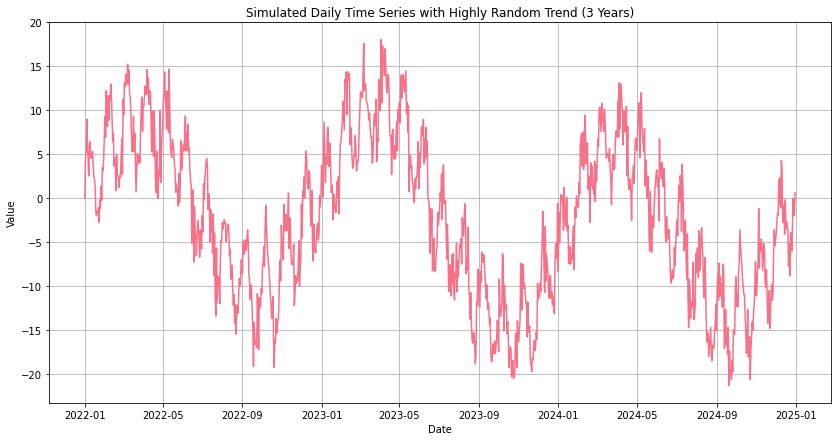

In [3]:
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Random walk without drift
trend_steps = np.random.normal(loc=[0], scale=0.2, size=len(dates))
trend = np.cumsum(trend_steps)

yearly_seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
monthly_seasonality = 5 * np.sin(2 * np.pi * dates.day / 30)
noise = np.random.normal(loc=0, scale=2, size=len(dates))

data = trend + yearly_seasonality + monthly_seasonality + noise

time_series = pd.DataFrame(data, index=dates)
time_series = time_series.reset_index()
time_series.columns = ['date', 'values']

plt.figure(figsize=(14, 7))
plt.plot(time_series.set_index('date')['values'])
plt.title('Simulated Daily Time Series with Highly Random Trend (3 Years)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [4]:
from time_series_data_nature_discovery import SeasonalityDetector

In [21]:
class TimeSeriesForcastor(SeasonalityDetector):
    def __init__(self, data, date_column, value_column):
        super().__init__(data, date_column, value_column)
        self.train_ts, self.val_ts, self.test_ts = self.__class__.split_time_series(self.ts)
        print(self.train_ts)
            
    @staticmethod
    def split_time_series(ts, train_pct=0.7, val_pct=0.15, test_pct=0.15):
        """
        Splits a time series chronologically into training, validation, and test sets.

        Args:
            ts (pd.Series): The time series data with a DatetimeIndex.
            train_pct (float): Percentage of data for the training set.
            val_pct (float): Percentage of data for the validation set.
            test_pct (float): Percentage of data for the test set.

        Returns:
            tuple: A tuple containing (train, val, test) pandas Series.
        """
        if round(train_pct + val_pct + test_pct, 10) != 1.0:
            raise ValueError("Percentages must sum to 1.0")

        n = len(ts)

        # Calculate split points
        train_end_idx = int(n * train_pct)
        val_end_idx = int(n * (train_pct + val_pct))

        # Split the data
        train_data = ts.iloc[:train_end_idx]
        val_data = ts.iloc[train_end_idx:val_end_idx]
        test_data = ts.iloc[val_end_idx:]

        print("--- Time Series Split ---")
        print(f"Training Set:   {len(train_data)} points ({train_data.index.min().date()} to {train_data.index.max().date()})")
        print(f"Validation Set: {len(val_data)} points ({val_data.index.min().date()} to {val_data.index.max().date()})")
        print(f"Test Set:       {len(test_data)} points ({test_data.index.min().date()} to {test_data.index.max().date()})")
        
        return train_data, val_data, test_data

In [22]:
time_series_ssd = TimeSeriesForcastor(time_series, date_column = 'date', value_column = 'values')

--- Time Series Split ---
Training Set:   767 points (2022-01-01 to 2024-02-06)
Validation Set: 164 points (2024-02-07 to 2024-07-19)
Test Set:       165 points (2024-07-20 to 2024-12-31)
date
2022-01-01    0.061435
2022-01-02    4.552206
2022-01-03    5.399634
2022-01-04    9.000638
2022-01-05    5.549900
                ...   
2024-02-02    1.802942
2024-02-03    0.531561
2024-02-04    6.025308
2024-02-05    6.958912
2024-02-06    7.389028
Name: values, Length: 767, dtype: float64


In [17]:
time_series_ssd.basic_statistics()

=== BASIC STATISTICS ===
Period: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Total observations: 1096
Mean: -2.1164
Std: 8.8264
Min: -21.2502
Max: 18.0398
Missing values: 0
